# Homerwork-2

In [19]:
#importing necessary libraries
import numpy as np
import json
import pandas as pd
from twitter import *
from networkx import edge_betweenness_centrality
from random import random

In [ ]:
# Loading authentication tokens
with open('auth_dict','r') as f:
    twtr_auth = json.load(f)

# To make it more readable, lets store
# the OAuth credentials in strings first.
CONSUMER_KEY = twtr_auth['consumer_key']
CONSUMER_SECRET = twtr_auth['consumer_secret']
OAUTH_TOKEN = twtr_auth['token']
OAUTH_TOKEN_SECRET = twtr_auth['token_secret']
    
# Then, we store the OAuth object in "auth"
auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)
# Notice that there are four tokens - you need to create these in the
# Twitter Apps dashboard after you have created your own "app".

# We now create the twitter search object.
t = Twitter(auth=auth)

In [3]:
#import libraries
import sys
import time
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        if e.e.code == 401:
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function

    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [4]:
# This will let us create new partial
# functions with arguments set to 
# certain values.
from functools import partial

# This was maxint.
# There is no longer a maxint (in Python 3)
from sys import maxsize


def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                                friends_limit=maxsize, followers_limit=maxsize):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # You can also do this with a function closure.
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids,
                                count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids,
                                count=5000)
    friends_ids, followers_ids = [], []
    for twitter_api_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
            ]:
        #LOOK HERE! This little line is important.
        if limit == 0: continue
        cursor = -1
        while cursor != 0:
            # Use make_twitter_request via the partially bound callable...
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
            print('Fetched {0} total {1} ids for {2}'.format(len(ids),
                    label, (user_id or screen_name), file=sys.stderr))
            if len(ids) >= limit or response is None:
                break
    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]



In [5]:
# Create a mostly empty data frame,
# and write it to a CSV file.
df = pd.DataFrame(columns=['ID','followers'])
df.to_csv('followers.csv', index=False,header=False)

# Our function
def save_followers(fid, followers):
    df = pd.DataFrame([[fid, followers]])
    with open('followers.csv', 'a') as f:
        df.to_csv(f,header=False, index=False)

#### get_user_profile() function is used to followers count of the given user, in order to get the Top-5 friends based on maximum followers count

In [6]:
def get_user_profile(twitter_api, screen_names=None, user_ids=None):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None), \
    "Must have screen_names or user_ids, but not both"
    items_to_info = {}
    items = screen_names or user_ids 
    while len(items) > 0:
        # Process 100 items at a time per the API specifications for /users/lookup.
        items_str = ','.join([str(item) for item in items[:100]]) 
        items = items[100:]
        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup,screen_name=items_str)
        else:
            response = make_twitter_request(twitter_api.users.lookup,
                                            user_id=items_str)
        for user_info in response: 
            if screen_names:
                items_to_info[user_info['screen_name']] = user_info['followers_count'] 
            else: 
                # user_ids
                items_to_info[user_info['id']] = user_info['followers_count']  
    #returning the follower coun for user_id        
    return items_to_info


### Crawl Function() will build th Friendship Graph:

1) Start with user with more than 10,000 followers

2)Fetch its reciprocal friends

3)Then, from step-2 get its Top-5 reciprocal friends using the above get_user_profile() function

4)Append these to the csv file in order to create ege list

5)Then repeat the steps 2-4 till distance-3 so that we get atleast 100 nodes for graph


This will give followers.csv file which will be used to plot the community detection graph

In [8]:
#Function to populate friendship edges into followers.csv file
def crawl_followers(twitter_api, screen_name, limit=1000000, depth=2):
    
    # Resolve the ID for screen_name and start working with IDs for consistency
    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    friends_id, followers_id = get_friends_followers_ids(twitter_api, user_id=seed_id,
                                            friends_limit=10000, followers_limit=limit)
        
    follower_count={}
    # Computing reciprocal friends
    reciprocal_friends = list(set(friends_id) & set(followers_id))
    #Top-5 reciprocal friends
    follower_count=get_user_profile(t, screen_names=None,user_ids=reciprocal_friends)
    #sorting the top friends
    top5_friends=sorted(follower_count, key=follower_count.get, reverse=True)[:5]

    #Appending to csv file
    for user_id, friend_id in [(user_id, friend_id) for user_id in [int(seed_id)] 
        for friend_id in top5_friends]:
        save_followers(user_id, friend_id)

    #initializing the depth
    d = 1

    #queue to store next top-5
    queue=[]
    #main queue for getting top-5 friends
    next_queue = list(top5_friends)
    #to filter already retrieved friends to get distinct followers
    all_nodes = list(top5_friends)
    
    while d < depth:
        d += 1
        # Reset the next_queue so that we can
        # start building up the next level
        # of followers-of-followers
        queue = list(next_queue)
        
        next_queue= []
        # Loop through the current
        # level of followers
        for fid in queue:
             # Resolve the ID for screen_name and start working with IDs for consistency
            friends_id, followers_id = get_friends_followers_ids(twitter_api, user_id=fid,
                        friends_limit=10000, followers_limit=limit)
    
            follower_count={}
            # Computing reciprocal friends
            reciprocal_friends = list(set(friends_id) & set(followers_id))
            follower_count=get_user_profile(t, screen_names=None,user_ids=reciprocal_friends)
            #sorting the nodes
            friends_ordered = sorted(follower_count, key=follower_count.get, reverse=True)
            #get unique id's by removing previously taken friends
            top5_friends= [friend_id for friend_id in friends_ordered if friend_id not in all_nodes][:5]

            # Store an ID with a string recording
            for user_id, friend_id in [(user_id, friend_id) for user_id in [int(fid)] 
                                       for friend_id in top5_friends]:
                save_followers(user_id, friend_id)

            # Updating the list
            next_queue += top5_friends
            #this will remove the friends which are already in the edge list to get distinct followers
            all_nodes += top5_friends

In [9]:
#Getting followers of user with more than 12,5000 followers 
#Finding till distance-3 friends 
#It will give 156 nodes
crawl_followers(t, 'Ronald_vanLoon', limit=10000, depth=3)

Fetched 5000 total friends ids for 555031989
Fetched 10000 total friends ids for 555031989
Fetched 5000 total followers ids for 555031989
Fetched 10000 total followers ids for 555031989
Fetched 5000 total friends ids for 15671604
Fetched 10000 total friends ids for 15671604
Fetched 5000 total followers ids for 15671604
Fetched 10000 total followers ids for 15671604
Fetched 5000 total friends ids for 291554279
Fetched 10000 total friends ids for 291554279
Fetched 5000 total followers ids for 291554279
Fetched 10000 total followers ids for 291554279
Fetched 5000 total friends ids for 396764205
Fetched 10000 total friends ids for 396764205
Fetched 5000 total followers ids for 396764205
Fetched 10000 total followers ids for 396764205
Fetched 5000 total friends ids for 417345114
Fetched 10000 total friends ids for 417345114
Fetched 5000 total followers ids for 417345114
Fetched 10000 total followers ids for 417345114
Fetched 5000 total friends ids for 602967876
Fetched 10000 total friends i

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


Fetched 5000 total friends ids for 33923443


...ZzZ...Awake now and trying again.


Fetched 10000 total friends ids for 33923443
Fetched 5000 total followers ids for 33923443
Fetched 10000 total followers ids for 33923443
Fetched 5000 total friends ids for 242637589
Fetched 10000 total friends ids for 242637589
Fetched 5000 total followers ids for 242637589
Fetched 10000 total followers ids for 242637589
Fetched 5000 total friends ids for 87710468
Fetched 10000 total friends ids for 87710468
Fetched 5000 total followers ids for 87710468
Fetched 10000 total followers ids for 87710468
Fetched 5000 total friends ids for 84860555
Fetched 10000 total friends ids for 84860555
Fetched 5000 total followers ids for 84860555
Fetched 10000 total followers ids for 84860555
Fetched 5000 total friends ids for 2257089540
Fetched 10000 total friends ids for 2257089540
Fetched 5000 total followers ids for 2257089540
Fetched 10000 total followers ids for 2257089540
Fetched 5000 total friends ids for 1870769611
Fetched 10000 total friends ids for 1870769611
Fetched 5000 total followers 

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


Fetched 5000 total followers ids for 2918130479


...ZzZ...Awake now and trying again.


Fetched 10000 total followers ids for 2918130479
Fetched 5000 total friends ids for 492991594
Fetched 10000 total friends ids for 492991594
Fetched 5000 total followers ids for 492991594
Fetched 10000 total followers ids for 492991594
Fetched 2234 total friends ids for 99069880
Fetched 5000 total followers ids for 99069880
Fetched 10000 total followers ids for 99069880
Fetched 2051 total friends ids for 3313309318
Fetched 5000 total followers ids for 3313309318
Fetched 10000 total followers ids for 3313309318
Fetched 4402 total friends ids for 589123971
Fetched 5000 total followers ids for 589123971
Fetched 10000 total followers ids for 589123971
Fetched 5000 total friends ids for 838078213
Fetched 10000 total friends ids for 838078213
Fetched 5000 total followers ids for 838078213
Fetched 10000 total followers ids for 838078213
Fetched 4190 total friends ids for 1239685879
Fetched 5000 total followers ids for 1239685879
Fetched 10000 total followers ids for 1239685879
Fetched 5000 tot

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


Fetched 10000 total friends ids for 244280163


...ZzZ...Awake now and trying again.


Fetched 5000 total followers ids for 244280163
Fetched 10000 total followers ids for 244280163
Fetched 5000 total friends ids for 16126957
Fetched 10000 total friends ids for 16126957
Fetched 5000 total followers ids for 16126957
Fetched 10000 total followers ids for 16126957
Fetched 5000 total friends ids for 714481697862127618
Fetched 10000 total friends ids for 714481697862127618
Fetched 5000 total followers ids for 714481697862127618
Fetched 10000 total followers ids for 714481697862127618
Fetched 5000 total friends ids for 2472651750
Fetched 6120 total friends ids for 2472651750
Fetched 5000 total followers ids for 2472651750
Fetched 10000 total followers ids for 2472651750
Fetched 5000 total friends ids for 1055384082
Fetched 10000 total friends ids for 1055384082
Fetched 5000 total followers ids for 1055384082
Fetched 10000 total followers ids for 1055384082
Fetched 5000 total friends ids for 2190593537
Fetched 10000 total friends ids for 2190593537
Fetched 5000 total followers 

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


Fetched 5000 total followers ids for 3027278530


...ZzZ...Awake now and trying again.


Fetched 10000 total followers ids for 3027278530
Fetched 5000 total friends ids for 3597650116
Fetched 10000 total friends ids for 3597650116
Fetched 5000 total followers ids for 3597650116
Fetched 10000 total followers ids for 3597650116


### The friendship graph for the above account’s followers.

In [4]:
#Necessary Libraies to be imported
import networkx as nx
import matplotlib.pyplot as plt

In [13]:
#read edgelist from the followers.csv file which is loaded using above Crawl_followers function
#i have turned Header as False since i don't want to fetch header
# Columns: ID , Followers

G=nx.read_edgelist('followers.csv',delimiter=',')
#nodes renaming 
n=[]
for i in range(len(G.nodes())):
    n.append(i+1)   
mapping=dict(zip(G.nodes(),n))
Graph=nx.relabel_nodes(G,mapping) # nodes 1.....
#A = nx.to_numpy_matrix(Graph)

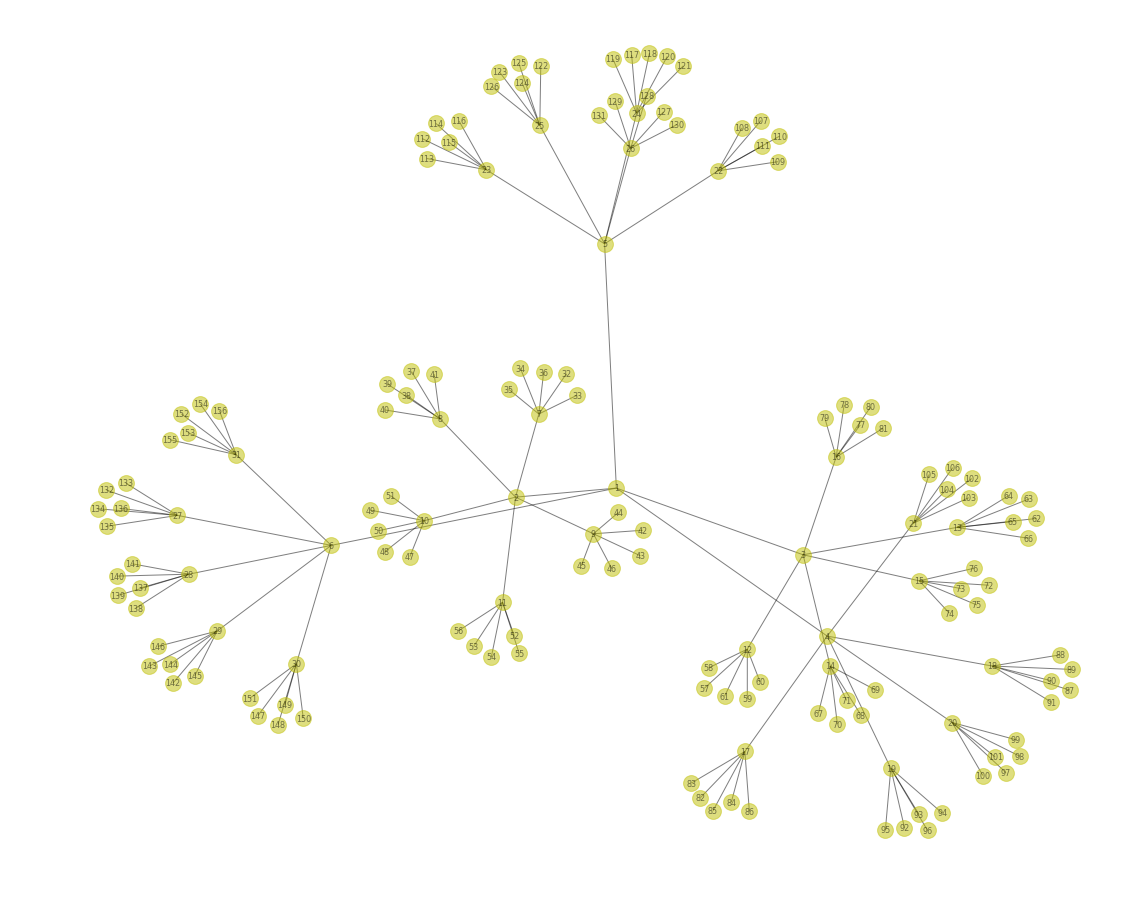

In [15]:
#Drawing the Orginal Friendship graph
nx.draw(Graph,pos=nx.spring_layout(Graph),with_labels=True,font_size=8,node_color='y',node_size=250,alpha=0.5)
plt.show()

### Community detection using Norman-Girvan Algorithm  based on edge-betweeneness

Algorithm:(Divisive Hierarchical Clustering)

1)It detects communities by progressively removing edges from the original graph

2)It will removes the “most valuable” edge, that is the edge with the highest betweenness centrality, at each step. 

3)As the graph breaks down into pieces, the tightly knit community structure is exposed

It is upto user that, till what depth, you want to break. I have break down the graph into communities till level-4(divisive clustering)

In [9]:
#Function to calculate edge betweenness for every edge 

def most_central_edge(G):
    centrality = edge_betweenness_centrality(G)

    max_cent = max(centrality.values())
    # Scale the centrality values so they are between 0 and 1,
    centrality = {e: c / max_cent for e, c in centrality.items()} 
    # Add some random noise.
    centrality = {e: c + random() for e, c in centrality.items()}
    
    #returning most central edge
    return max(centrality, key=centrality.get)

In [10]:
#Function to get communiites by  above algorithm
def Get_Communities():
    
    community=[]
    from networkx.algorithms.community.centrality import girvan_newman
    comp = girvan_newman(Graph, most_valuable_edge=most_central_edge)
    
    for i in range(4):
        #tuple till depth 4(divisive clustering)
        communities_detected = next(comp)
    
    community=communities_detected
    return community

### Visual display of your graph such that nodes belonging to different communities are differently colored.

(-1.0316742715258584,
 0.909642162543651,
 -1.007675129422973,
 1.1183156984117695)

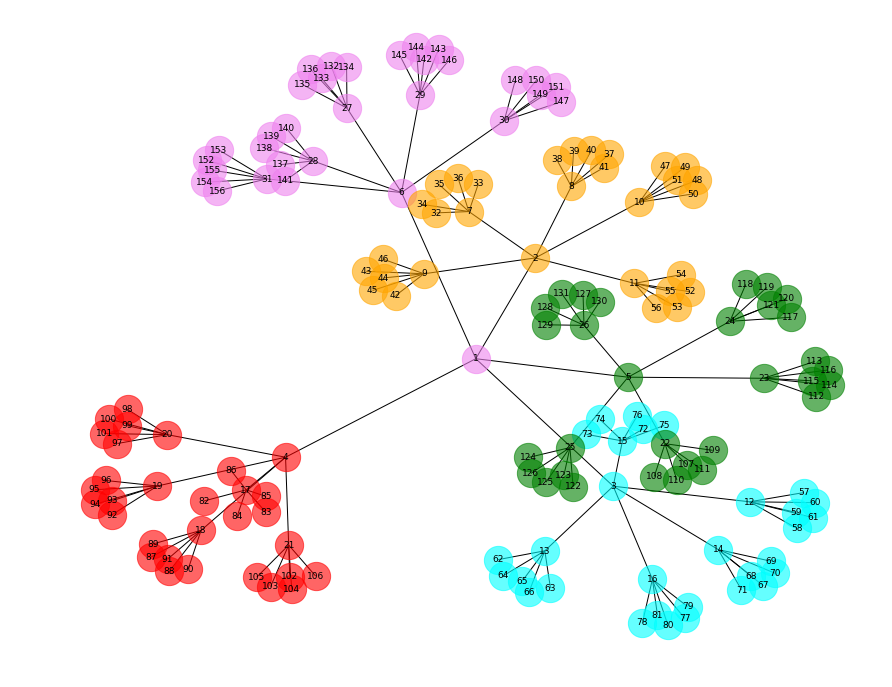

In [12]:
pos=nx.spring_layout(Graph)
#Assigning colors to communities
colors = ["violet","orange","cyan","red","green","yellow","indigo","pink"]
#getting different communities in a list for different colors
list_of_comm=Get_Communities()
#drawing graph based on communities
for i in range(len(list_of_comm)):
    comm_graph=list_of_comm[i]
    nlist = [node for node in comm_graph]
    nx.draw_networkx_nodes(Graph,pos,nodelist=nlist,node_color=colors[i%10],node_size=800,alpha=0.6)
     
nx.draw_networkx_edges(Graph,pos)
nx.draw_networkx_labels(Graph,pos,font_size=9,node_size=800)

#Resizing the graph for better visualization
fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 15 and height to 12
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.axis('off')